In [1]:
import contexttimer
from runlmc.models.lmc import LMC
from runlmc.kern.rbf import RBF
from runlmc.models.optimization import AdaDelta
import GPy
from runlmc.models.gpy_lmc import GPyLMC

import numpy as np
import pandas as pd

%matplotlib inline 
import matplotlib.pyplot as plt

np.random.seed(1234)

In [2]:
# Adapts the foreign currency exchange problem
# Collaborative Multi-output Gaussian Processes
# Nguyen and Bonilla et al. 2014

fx_files = ['2007-2009.csv', '2010-2013.csv', '2014-2017.csv']
fx = pd.concat([pd.read_csv('../data/fx/{}'.format(f), index_col=1) for f in fx_files])
fx.drop(['Wdy', 'Jul.Day'], axis=1, inplace=True)
fx.rename(columns={old: old[:3] for old in fx.columns}, inplace=True)

In [5]:
# Their example uses only 2007 data

fx2007 = fx.ix['2007/01/01':'2008/01/01']
fx2007_train = fx2007.copy()
# they did the experiment in R...
holdout = {'CAD': slice(49, 99), 
           'JPY': slice(99, 149), 
           'AUD': slice(149, 199)}
for col in fx2007.columns:
    if col not in holdout:
        holdout[col] = slice(0, 0)
holdin = {col: np.r_[0:ixs.start, ixs.stop:len(fx2007)]
          for col, ixs in holdout.items()}
    
xss = []
yss = []
all_ixs = np.arange(len(fx2007))
for col in fx2007.columns:
    select = np.ones(len(fx2007), dtype=bool)
    select[holdout[col]] = False
    select[fx2007[col].isnull().values] = False
    xss.append(all_ixs[select])
    currency2usd = fx2007_train[col][select].values
    # Don't ask me, this was in the Nguyen 2014 paper code
    usd2currency = np.reciprocal(currency2usd)
    yss.append(usd2currency)
    
# as chosen in Nguyen 2014
ks = [RBF(name='rbf0')]
ranks = [2]
    
lmc = LMC(xss, yss, kernels=ks, ranks=ranks, normalize=True)
opt = AdaDelta(max_it=100, verbosity=10)
with contexttimer.Timer() as t:
    lmc.optimize(optimizer=opt)
print('sec', t.elapsed)
print('ll', lmc.log_likelihood())

starting AdaDelta {'momentum': 0.5, 'step_rate': 1, 'max_it': 100, 'min_grad_ratio': 0.5, 'offset': 0.0001, 'roll': 2, 'verbosity': 10, 'decay': 0.9}
iteration       10 grad norm 2.6322e+02
iteration       20 grad norm 2.7646e+02
finished adadelta optimization
            23 iterations
    1.7530e+02 final grad norm
    1.3631e+02 final MA(2) grad norm
    3.3872e+02 max MA(2) grad norm
    norm used inf
sec 27.112844736000625
ll 990.450602331


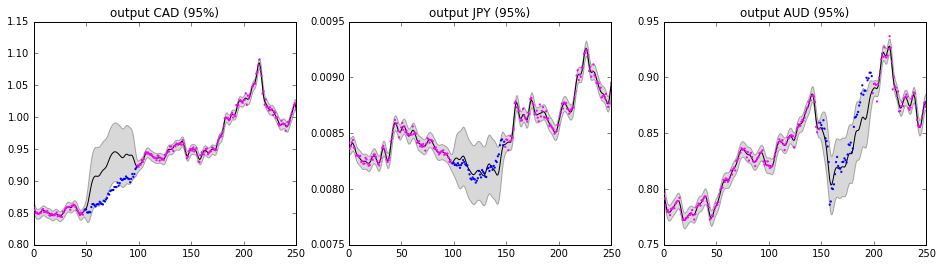

In [6]:
test_fx = ['CAD', 'JPY', 'AUD']
pred_xss = [all_ixs if col in test_fx else [] for col in fx2007.columns]
pred_yss, pred_vss = lmc.predict(pred_xss)
pred_xss = {col: xs for col, xs in zip(fx2007.columns, pred_xss)}
pred_yss = {col: ys for col, ys in zip(fx2007.columns, pred_yss)}
pred_vss = {col: vs for col, vs in zip(fx2007.columns, pred_vss)}

_, axs = plt.subplots(ncols=3, figsize=(16, 4))
for col, ax in zip(test_fx, axs):
    
    # Prediction everywhere
    pred_xs = pred_xss[col]
    pred_ys = pred_yss[col]
    sd = np.sqrt(pred_vss[col])
    ax.plot(pred_xs, pred_ys, c='black')
    top = pred_ys + 2 * sd
    bot = pred_ys - 2 * sd
    ax.fill_between(pred_xs, bot, top, facecolor='grey', alpha=0.3)    
    
    # Actual holdout
    marker_size = 5
    test_xs = all_ixs[holdout[col]]
    test_ys = np.reciprocal(fx2007.ix[holdout[col], col].values)
    ax.scatter(test_xs, test_ys, c='blue', edgecolors='none', s=marker_size, zorder=11)
    
    # Rest of image
    rest_xs = all_ixs[holdin[col]]
    rest_ys = np.reciprocal(fx2007.ix[holdin[col], col].values)
    ax.scatter(rest_xs, rest_ys, c='magenta', edgecolors='none', s=marker_size, zorder=10)
    
    ax.set_xlim([0, 250])
    ax.set_title('output {} (95%)'.format(col))


plt.show()

In [7]:
def smse(test_yss, pred_yss, train_yss):
    return [np.square(test_ys - pred_ys).mean() /
            np.square(train_ys.mean() - test_ys).mean() for
            test_ys, pred_ys, train_ys in
            zip(test_yss, pred_yss, train_yss)]

def nlpd(test_yss, pred_yss, pred_vss):
    return [0.5 * np.mean(
            np.square(test_ys - pred_ys) / pred_vs
            + np.log(2 * np.pi * pred_vs))
            for test_ys, pred_ys, pred_vs in
            zip(test_yss, pred_yss, pred_vss)]

In [9]:
test_fx_pred_yss = [pred_yss[col][holdout[col]] for col in test_fx]
test_fx_pred_vss = [pred_vss[col][holdout[col]] for col in test_fx]
test_fx_test_yss = [np.reciprocal(fx2007.ix[holdout[col], col]) for col in test_fx]
test_fx_train_yss = [np.reciprocal(fx2007.ix[holdin[col], col]) for col in test_fx]
print(np.mean(smse(test_fx_test_yss, test_fx_pred_yss, test_fx_train_yss)))
print(np.mean(nlpd(test_fx_test_yss, test_fx_pred_yss, test_fx_pred_vss)))

0.193301820989
-3.9513696734


In [2]:
# Adapts the 2-output toy problem from 
# Collaborative Multi-output Gaussian Processes
# Nguyen and Bonilla et al. 2014

# Their example uses a grid of inputs. To make it harder (for runlmc)
# we instead look at uniformly distributed inputs.

sz = 2000
xss = [np.random.uniform(-10,10,size=sz) for _ in range(2)]
yss = [np.sin(xss[0]) + 1e-7 + np.random.randn(sz) * 1e-2,
       -np.sin(xss[0]) + 1e-7 + np.random.randn(sz) * 1e-2]
ks = [RBF(name='rbf0')]

In [3]:
lmc = LMC(xss, yss, kernels=ks, normalize=False)
opt = AdaDelta(max_it=100, verbosity=10)
with contexttimer.Timer() as t:
    lmc.optimize(optimizer=opt)
t.elapsed, lmc.log_likelihood()

starting AdaDelta {'max_it': 100, 'step_rate': 1, 'offset': 0.0001, 'momentum': 0.5, 'verbosity': 10, 'min_grad_ratio': 0.5, 'roll': 2, 'decay': 0.9}
iteration       10 grad norm 8.0037e+02
iteration       20 grad norm 8.3000e+02
finished adadelta optimization
            22 iterations
    3.3281e+02 final grad norm
    3.8924e+02 final MA(2) grad norm
    9.7431e+02 max MA(2) grad norm
    norm used inf


(20.42438423691783, 4155.6073917252616)

In [4]:
dtcvar = GPyLMC(xss, yss, kernels=ks, ranks=[1], sparse=10)
with contexttimer.Timer() as t:
    dtcvar.optimize()
t.elapsed, dtcvar.log_likelihood()

(24.23004325304646, 4150.727811393328)

In [11]:
# Cholesky
chol = GPyLMC(xss, yss, kernels=ks, ranks=[1])
with contexttimer.Timer() as t:
    chol.optimize()
t.elapsed, chol.log_likelihood()

(172.1126094950596, 4263.5540570123285)